# Overview

This data of credit card transactions has been anonymized through Principle Components Analysis (PCA) with "Class" as the label for fraudulent (labelled as "1") or legitimate (labelled as "0") transactions. This analysis will run the data through a series of models to determine which one performs the best with an emphasis on minimizing the number of false negatives or Type II Errors.

In [392]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.model_selection import cross_val_score

%matplotlib inline

In [393]:
sms_raw = pd.read_csv('creditcard.csv')
sms_raw.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [394]:
# Count nulls 
null_count = sms_raw.isnull().sum()
null_count[null_count>0]

Series([], dtype: int64)

In [395]:
print(sms_raw['Class'].value_counts())

0    284315
1       492
Name: Class, dtype: int64


In [396]:
# Create a separate yes and no variable
fraud = df2[df2.Class == 1]
legit = df2[df2.Class == 0]

# Use resample to get an equal number of yes and nos in our data
model_df = resample(legit, n_samples=492)
model_df = model_df.append(fraud)

print(model_df['Class'].value_counts())

1    492
0    492
Name: Class, dtype: int64


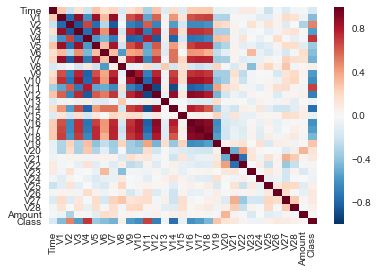

In [397]:
#See how the features relate to each other through a heatmap
sns.heatmap(model_df.corr())

In [398]:
#Set up our training/testing data
#Make a training and test set.
X = model_df.drop(['Class'], 1)
y = model_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [399]:
def testing_func(test):
    test.fit(X_train, y_train)
    print('The accuracy score of this model is: {}'.format(test.score(X_train, y_train)))
    
    predict_train = test.predict(X_train)
    predict_test = test.predict(X_test)

    # Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

    print((
        'Training set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}\n\n'
        'Test set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}'
    ).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))
    print('Mean of 10-fold cross validation: {}'.format(np.mean(cross_val_score(test, X_train, y_train, cv=10))))
    
    conf_mat = confusion_matrix(y_test, predict_test)
    mat_labels = ['Legitimate', 'Fraud']
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=mat_labels, yticklabels=mat_labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
                                                           
    

For each of the models, we'll get the overall accuracy score and then break down their score for type I and type II errors. Since we are focusing on catching fraudulent charges, it's helpful to break it down to false positives and false negatives. We then take their cross validation score to make sure it's not overly fitted to a pocket of our data.

## Bernoulli Bayes

The accuracy score of this model is: 0.9013657056145675
Training set accuracy:
Percent Type I errors: 0.006069802731411229
Percent Type II errors: 0.09256449165402124

Test set accuracy:
Percent Type I errors: 0.006153846153846154
Percent Type II errors: 0.07692307692307693
Mean of 10-fold cross validation: 0.8998093448839718


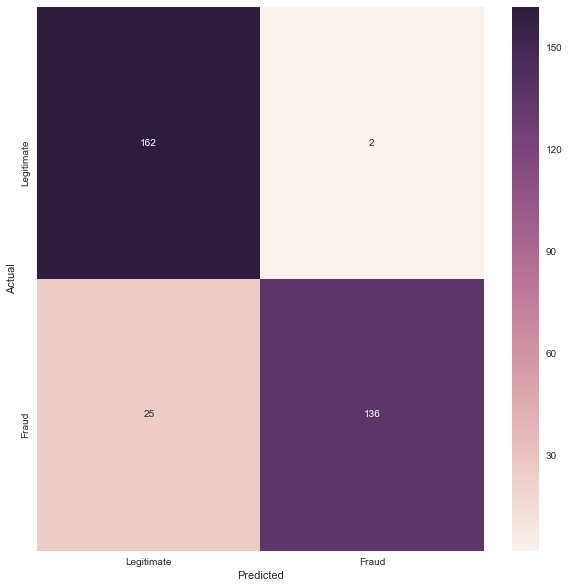

In [400]:
#Let's put our variables through Naive Bayes.
bnb = BernoulliNB()
testing_func(bnb)

## Lasso Regression

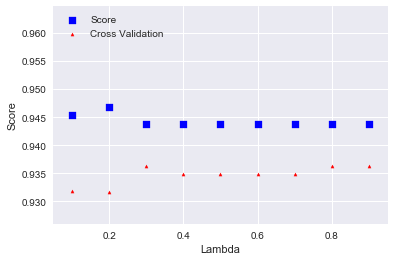

In [401]:
# Temporary lists to store the results
yl = []
cvl = []

# Run the model with number of neighbors as n again using the PCA_X.
numb = np.arange(0.1, 1, 0.1)
for n in numb:
    lr = LogisticRegression(C=n, penalty='l1')
    lr.fit(X_train, y_train)
    yl.append(lr.score(X_train, y_train))
    cvl.append(np.mean(cross_val_score(lr, X_train, y_train, cv=10)))

# Create a variable equal to the number of neighbors that created the highest CV
lr_number = cvl.index(max(cvl)) + 1
C_var = numb[lr_number]

# Plot the results
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.xlabel('Lambda')
plt.ylabel('Score')
ax1.scatter(x=numb, y=yr, c='b', marker="s", label='Score')
ax1.scatter(x=numb, y=cvr, s=10, c='r', marker="^", label='Cross Validation')
plt.legend(loc='upper left');
plt.show()


The accuracy score of this model is: 0.960546282245827
Training set accuracy:
Percent Type I errors: 0.007587253414264037
Percent Type II errors: 0.03186646433990895

Test set accuracy:
Percent Type I errors: 0.024615384615384615
Percent Type II errors: 0.046153846153846156
Mean of 10-fold cross validation: 0.9484587551751732


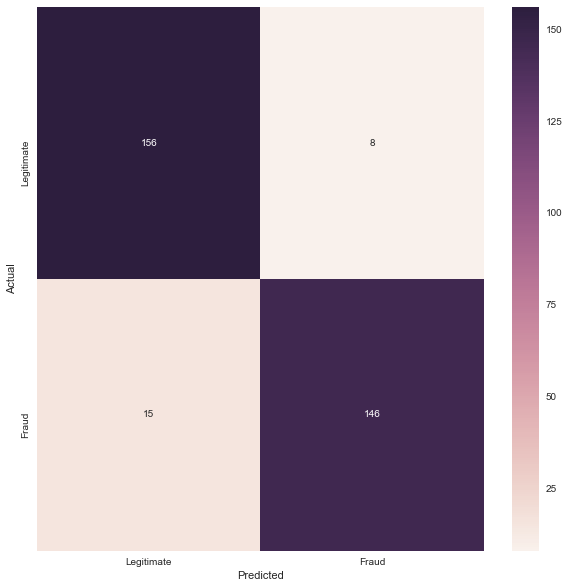

In [402]:
#Let's put our variables through Lasso.
lr = LogisticRegression(C=C_var, penalty='l1')
testing_func(lr)

## Ridge Regression

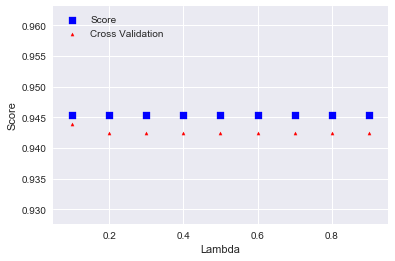

In [403]:
# Temporary lists to store the results
yr = []
cvr = []

# Run the model with number of neighbors as n.
numb = np.arange(0.1, 1, 0.1)
for n in numb:
    lr = LogisticRegression(C=n, penalty='l2')
    lr.fit(X_train, y_train)
    yr.append(lr.score(X_train, y_train))
    cvr.append(np.mean(cross_val_score(lr, X_train, y_train, cv=10)))

# Create a variable equal to the number of neighbors that created the highest CV
lr_number = cvr.index(max(cvr)) + 1
C_var = numb[lr_number]

# Plot the results
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.xlabel('Lambda')
plt.ylabel('Score')
ax1.scatter(x=numb, y=yr, c='b', marker="s", label='Score')
ax1.scatter(x=numb, y=cvr, s=10, c='r', marker="^", label='Cross Validation')
plt.legend(loc='upper left');
plt.show()


The accuracy score of this model is: 0.9453717754172989
Training set accuracy:
Percent Type I errors: 0.009104704097116844
Percent Type II errors: 0.04552352048558422

Test set accuracy:
Percent Type I errors: 0.009230769230769232
Percent Type II errors: 0.046153846153846156
Mean of 10-fold cross validation: 0.9424433775180046


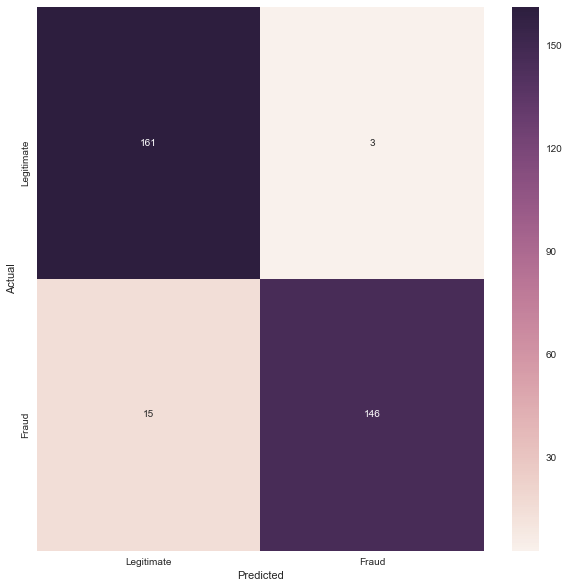

In [404]:
#Let's put our variables through Ridge Regression.

lr = LogisticRegression(C=1, penalty='l2')
testing_func(lr)

# K Nearest Neighbor

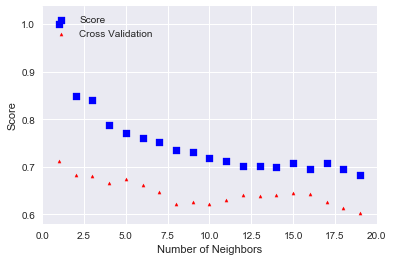

In [405]:
# This runs the same kind of optimization analysis on KNN.
# Temporary lists to store the results
yn = []
cv = []

# Run the model with number of neighbors as n again using the PCA_X.
numb = np.arange(1, 20, 1)
for n in numb:
    neighbors = KNeighborsClassifier(n_neighbors=n)
    neighbors.fit(X_train, y_train)
    yn.append(neighbors.score(X_train, y_train))
    cv.append(np.mean(cross_val_score(neighbors, X_train, y_train, cv=10)))

# Create a variable equal to the number of neighbors that created the highest CV
neighbor_number = cv.index(max(cv)) + 1

# Plot the results
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.xlabel('Number of Neighbors')
plt.ylabel('Score')
ax1.scatter(x=numb, y=yn, c='b', marker="s", label='Score')
ax1.scatter(x=numb, y=cv, s=10, c='r', marker="^", label='Cross Validation')
plt.legend(loc='upper left');
plt.show()


The accuracy score of this model is: 1.0
Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.11692307692307692
Percent Type II errors: 0.1476923076923077
Mean of 10-fold cross validation: 0.711713112757889


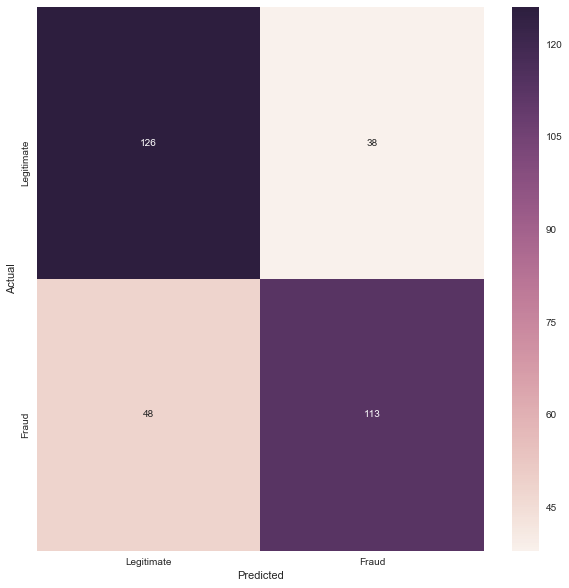

In [406]:
#Let's put our variables through a KNN Classifier.

neighbors = KNeighborsClassifier(n_neighbors=neighbor_number)
testing_func(neighbors)

## Support Vector Machines

In [407]:
# SKlearn has a tool that will optimize SVC
svc = SVC()
# Set the hyperparameters
parameters = {'C':[1,2,3,4,5], 'gamma': 
              [0.01,0.02,0.03,0.04,0.05,0.10]}
# Run it through the tool.
grid = GridSearchCV(svc, parameters).fit(X_train, y_train)
predicted = grid.predict(X_test)
print("The best parameters are {} with a score of %{}".format(grid.best_params_, grid.best_score_))

#Put those parameters in a dictionary to call.
parameters = grid.best_params_


The best parameters are {'C': 1, 'gamma': 0.01} with a score of %0.6494688922610015


The accuracy score of this model is: 1.0
Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.25846153846153846
Percent Type II errors: 0.0
Mean of 10-fold cross validation: 0.6919427338830324


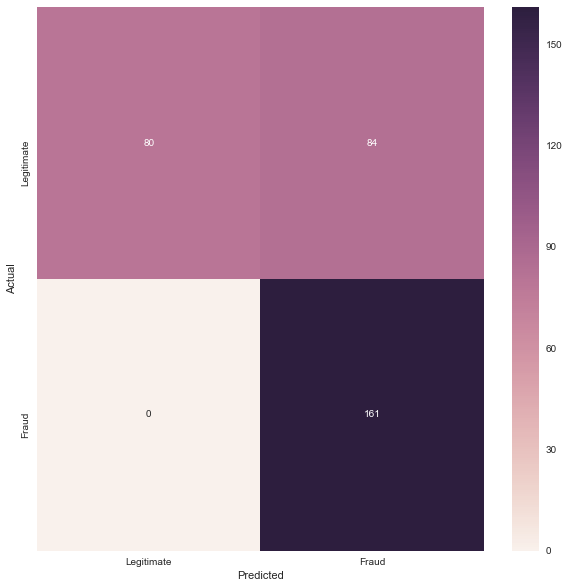

In [408]:
# Utilizing the results from above, we can run SVC aimed at the highest CV score.

svc = SVC(C=parameters['C'], gamma=parameters['gamma'])
testing_func(svc)


## Decision Tree

In [409]:
clf = DecisionTreeClassifier(criterion='entropy')
parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}
grid = GridSearchCV(clf, parameters).fit(X_train, y_train)
predicted = grid.predict(X_train)
print("The best parameters are {} with a score of %{}".format(grid.best_params_, grid.best_score_))

#Put those parameters in a dictionary to call.
parameters = grid.best_params_


The best parameters are {'max_depth': 1} with a score of %0.921092564491654


The accuracy score of this model is: 0.9301972685887708
Training set accuracy:
Percent Type I errors: 0.010622154779969651
Percent Type II errors: 0.05918057663125948

Test set accuracy:
Percent Type I errors: 0.027692307692307693
Percent Type II errors: 0.06461538461538462
Mean of 10-fold cross validation: 0.9181084090039315


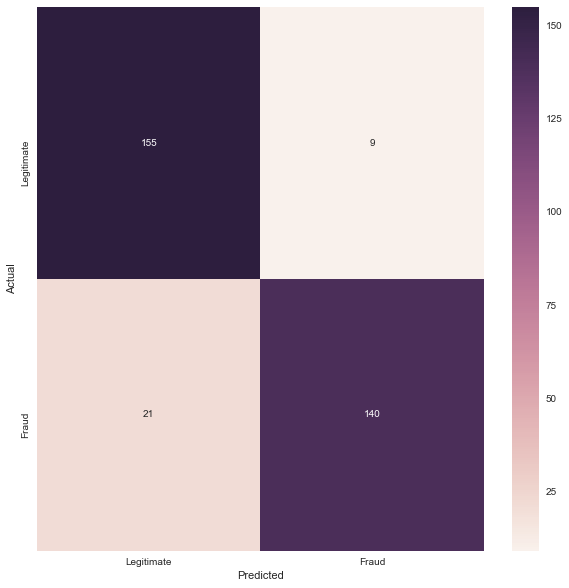

In [410]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=parameters['max_depth'])
testing_func(clf)


## Random Forest

In [411]:
rfc = RandomForestClassifier()
parameters = {'n_estimators':[10, 100, 500], 'max_depth':[2,4,6,8]}
grid = GridSearchCV(rfc, parameters).fit(X_train, y_train)
predicted = grid.predict(X_test)
print("The best parameters are {} with a score of %{}".format(grid.best_params_, grid.best_score_))

#Put those parameters in a dictionary to call.
parameters = grid.best_params_

The best parameters are {'max_depth': 6, 'n_estimators': 100} with a score of %0.9347496206373292


The accuracy score of this model is: 0.936267071320182
Training set accuracy:
Percent Type I errors: 0.004552352048558422
Percent Type II errors: 0.05918057663125948

Test set accuracy:
Percent Type I errors: 0.012307692307692308
Percent Type II errors: 0.06461538461538462
Mean of 10-fold cross validation: 0.9363135372090596


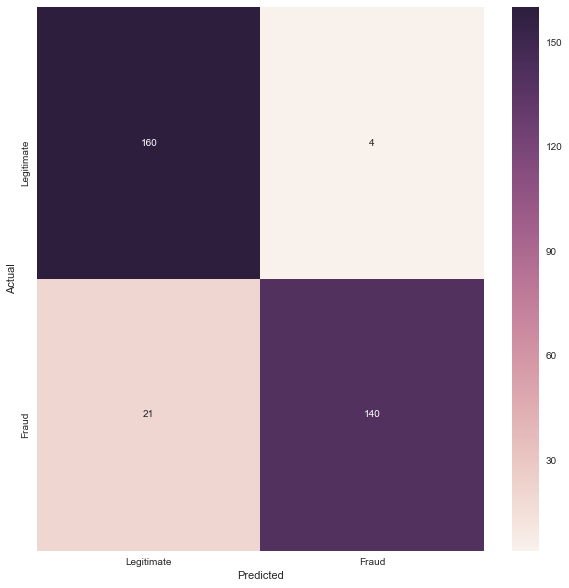

In [412]:
#Let's put our variables through a random forest classifer.

rfc = RandomForestClassifier(n_estimators=parameters['n_estimators'],
                             max_depth=parameters['max_depth'], 
                             min_samples_leaf=1, 
                             max_leaf_nodes=4)

testing_func(rfc)

## Gradient Boosting

In [413]:
clf = GradientBoostingClassifier()
parameters = {'n_estimators':[20, 50, 75, 100], 'learning_rate': [0.1, 0.25, 0.5, 0.75, 1.0],
              'max_depth':[2,4]}
grid = GridSearchCV(clf, parameters).fit(X_train, y_train)
predicted = grid.predict(X_test)
print("The best parameters are {} with a score of %{}".format(grid.best_params_, grid.best_score_))

#Put those parameters in a dictionary to call.
parameters = grid.best_params_

The best parameters are {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50} with a score of %0.9317147192716236


The accuracy score of this model is: 0.9544764795144158
Training set accuracy:
Percent Type I errors: 0.009104704097116844
Percent Type II errors: 0.036418816388467376

Test set accuracy:
Percent Type I errors: 0.018461538461538463
Percent Type II errors: 0.046153846153846156
Mean of 10-fold cross validation: 0.936290923007341


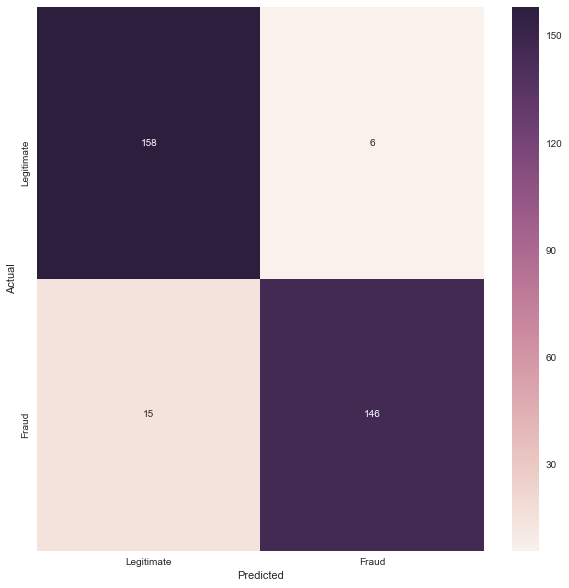

In [414]:
#Let's put our variables through a gradient booster.
clf = GradientBoostingClassifier(loss='exponential', learning_rate=parameters['learning_rate'], 
                                 n_estimators=parameters['n_estimators'], subsample=0.75, 
                                 max_depth=parameters['max_depth'])

testing_func(clf)

# Conclusion
Type 2 Errors are critical in fraud detection, where it is better to be safe than sorry and one would rather call a legitimate transaction fraud than to call a fraudulent transaction legitimate. Therefore, the lower lefthand box is the most critical to look at when assessing the performance of a model. Of all of the above models, Logistic Regression and Gradient Boosting (Decision Tree based algorithm) performed the best. In addition to minimizing the number of false negatives, speed is critical since most of these analyses will be done at Point of Sale and the longer the customer has to wait to complete a purchase, the unhappier the customer and business. 

Therefore, even though the optimized Gradient Boosting performs relatively the same as the Logistic Regression models with slightly fewer Type 1 Errors, it would be best to sacrifice a few false positives for speed.